<center> Appendix </center>

<h1><center>Bayesian Network model</center></h1>

## Data

### Importing Necessary libraries

In [1]:
# import tools and libraries

import pandas as pd
import requests
from zipfile import ZipFile
from io import BytesIO

#tools to analyze categorical variable association
import os as os
from itertools import product
import numpy as np
import scipy.stats as ss

# tools to visualize data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# tools to build bayesian network
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD 
import networkx as nx

# tool to make inference from bayesian network 
from pgmpy.inference import VariableElimination

### Exploratory Data Analysis

In [2]:
# read data from online data base
r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip")
files = ZipFile(BytesIO(r.content))
bank_full=pd.read_csv(files.open("bank-additional/bank-additional-full.csv"), sep=';')

# code refence: 
# https://stackoverflow.com/questions/61894641/using-pandas-how-to-read-a-csv-file-inside-a-zip-file-which-you-fetch-using-an


In [3]:
# quick look at the data
bank_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# data features & information
bank_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# statistics of numerical features
bank_full.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# statistics of categorical features
bank_full.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [7]:
# categories of target variable
bank_full.y.unique()

array(['no', 'yes'], dtype=object)

In [8]:
# check null values in data
bank_full.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### bank client data

#### Statistics of bank client characteristic features

In [9]:
# what are the bank client feature?
client_feat = bank_full.columns[:7]
print(client_feat)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')


In [10]:
# types of features
bank_full[client_feat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        41188 non-null  int64 
 1   job        41188 non-null  object
 2   marital    41188 non-null  object
 3   education  41188 non-null  object
 4   default    41188 non-null  object
 5   housing    41188 non-null  object
 6   loan       41188 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.2+ MB


In [11]:
# stats of "age"
bank_full[client_feat].describe()

,age
count,41188.00000
mean,40.02406
std,10.42125
min,17.00000
25%,32.00000
50%,38.00000
75%,47.00000
max,98.00000


In [12]:
# bank client characteristic categorical feature distribution 
for feat in client_feat[1:7]:
    print(bank_full[feat].value_counts())

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64


#### Pre-process bank client features

In [13]:
# drop rare categories under different features
rare = bank_full.loc[(bank_full["education"] == "illiterate") 
                     | (bank_full["marital"] == "unknown")
                     |(bank_full['job']=='unknown')]
bank_full = bank_full.drop(index=rare.index)

In [14]:
# combine categories "basic.4y", 'basic.6y', 'basic.9y' as 'basic'
bank_full['education'] = bank_full['education'].replace(["basic.4y", 'basic.6y', 'basic.9y'], "basic")

<AxesSubplot:xlabel='age', ylabel='Count'>

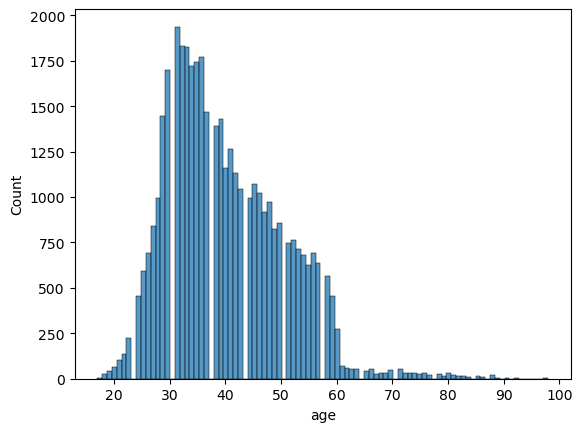

In [15]:
# visualize the age feature distribution
sns.histplot( bank_full['age'])

In [16]:
# discretize age feature
bank_full['age'] = bank_full['age'].apply(
                    lambda x: "0.<30"  if x <= 30 else
                    "1.30~50" if 30 < x <= 50 else
                    "2.>50" )

#### Test the associations between different bank client features using Chi-square tests

In [17]:
# features to pair up and be tested by chi2 to see if feature pair are independent from each other
chi2_feat = list(client_feat)
chi2_feat.append('y')
print(chi2_feat)

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']


In [18]:
# pairing up different features
group1 = chi2_feat
group2 = chi2_feat
feat_pair = list(product(group1, group2, repeat=1))
# quick look at feature pairs
feat_pair[:5]

[('age', 'age'),
 ('age', 'job'),
 ('age', 'marital'),
 ('age', 'education'),
 ('age', 'default')]

In [19]:
# calculate chi2 test p-value for each feature pair
result = []
for i in feat_pair: 
    if i[0] != i[1]: # exclude a feature pair only containing itself
        result.append((i[0], i[1], 
                       list( ss.chi2_contingency(pd.crosstab(bank_full[chi2_feat][i[0]],
                                                             bank_full[chi2_feat][i[1]])))[1]))

In [20]:
# total number of feature pairs calculated
len(result)

56

In [21]:
# tabulate the pair-wise results 
p_value = pd.DataFrame(result,
                       columns = ['features_', 'features', 'p']).pivot(
                       index='features_', columns='features', values='p').round(decimals=3)

There is association between 2 variables if p<0.05. y is not associated with (housing, loan),other variables are correlated with each other.


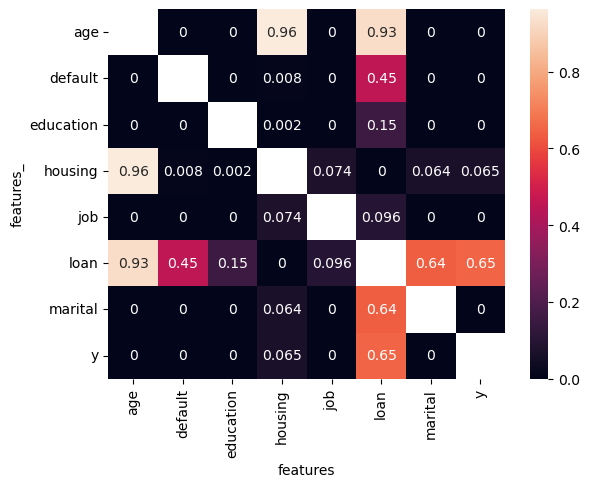

In [22]:
# visualize Chi2 test result (p-values)
sns.heatmap(p_value, annot=True)
print('There is association between 2 variables if p<0.05. y is not associated with (housing, loan),\
other variables are correlated with each other.')

"y" is associated with age, default, education, job, and marital—no association with housing or loan. We are not interested in "default". Hence, the selected features would be "age", "job", "marital" and "education".

#### Visualized association between selected feature pairs

In [23]:
# pair up selected features including y
pairs = list(product(["age", "job", "marital", "education", "y"], ["age", "job", "marital", "education", "y"], repeat=1))
# delete the pairs where feature pair with itself
for pair in pairs:
    if pair[0] == pair[1]:
        pairs.remove(pair)

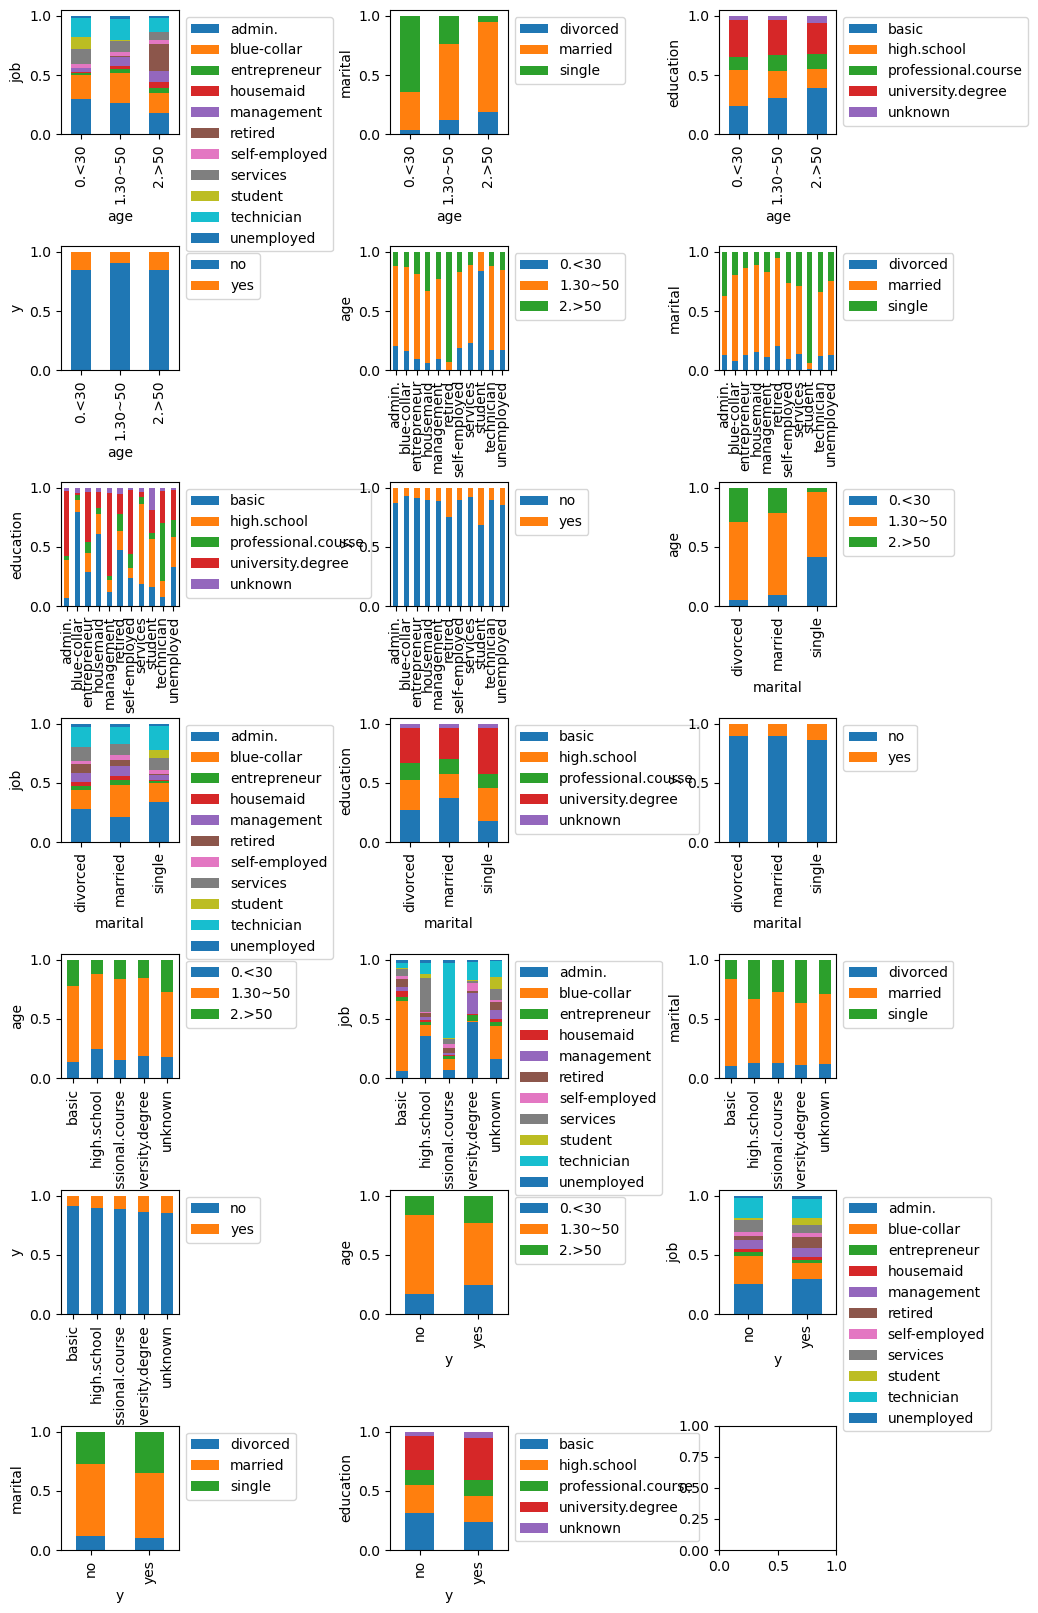

In [24]:
# visualize paired features distribution

# set a subplot grid
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 20))
# set heights and widths between axes
plt.subplots_adjust(hspace=0.9, wspace=1.8)
# plot feature pairs on axes
for pair, ax in zip(pairs, axs.ravel()):
    # exclude pairs which feature paired with itself
    pd.crosstab(bank_full[pair[0]], bank_full[pair[1]], normalize='index').plot(kind='bar',stacked=True, ax=ax)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel(pair[1])
plt.show()

There are some significant associations as follow:

1.	Age had an evident influence on random variables “job”, “marital”, and “education”

    a.	The marriage and divorce ratio rose when age increased, while the singular ratio decreased.
    
    b.	Older generations (age above 50) tend to have more basic education and less high school education
    
    c.	Most people over 60 were retired, and most students were below 30.
    
    
2.	Students and retired people are more willing to subscribe to a term than people with other jobs status.


3.	Students tend to be single, while the divorce rate rises significantly in retired people.


4.	Most people with “basic” education become “blue-collar”, while the majority of “professional.cource” takers are technicians.


### social and economic context attributes

In [25]:
# name an object "SE" to represent social and economic features and "y"
SE = bank_full.iloc[:,15:].replace({'y':{'yes':1, 'no':0}})

In [26]:
SE.corr().round(decimals=2)

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
emp.var.rate,1.00,0.78,0.20,0.97,0.91,-0.30
cons.price.idx,0.78,1.00,0.06,0.69,0.52,-0.14
cons.conf.idx,0.20,0.06,1.00,0.28,0.10,0.05
euribor3m,0.97,0.69,0.28,1.00,0.95,-0.31
nr.employed,0.91,0.52,0.10,0.95,1.00,-0.35
y,-0.30,-0.14,0.05,-0.31,-0.35,1.00


<AxesSubplot:>

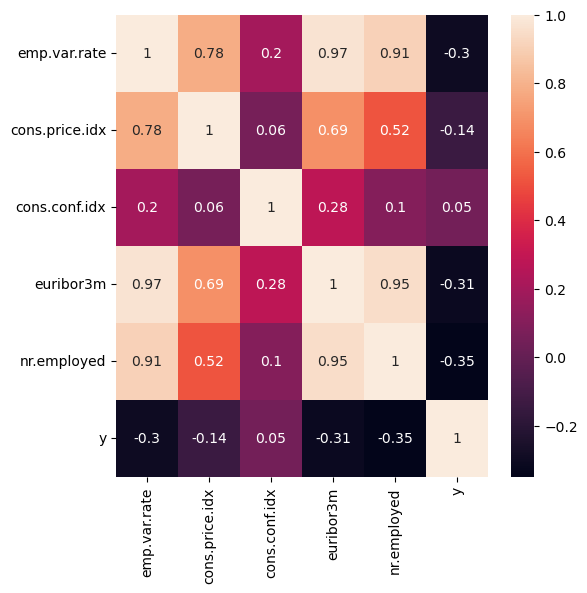

In [27]:
# visualize correlations between variables
plt.figure(figsize=(6,6))
sns.heatmap(SE.corr().round(decimals=2), annot=True)

It seems 'emp.var.rate' could informativly represent 'euribor3m' and 'nr.employed', while 'cons.conf.idx' is not informative to 'y'

In [28]:
# stats of "SE"
SE[['emp.var.rate', 'cons.price.idx']].describe()

,emp.var.rate,cons.price.idx
count,40769.000000,40769.000000
mean,0.080610,93.574918
std,1.570076,0.578516
min,-3.400000,92.201000
25%,-1.800000,93.075000
50%,1.100000,93.749000
75%,1.400000,93.994000
max,1.400000,94.767000


##### Discretize continous social and economic features

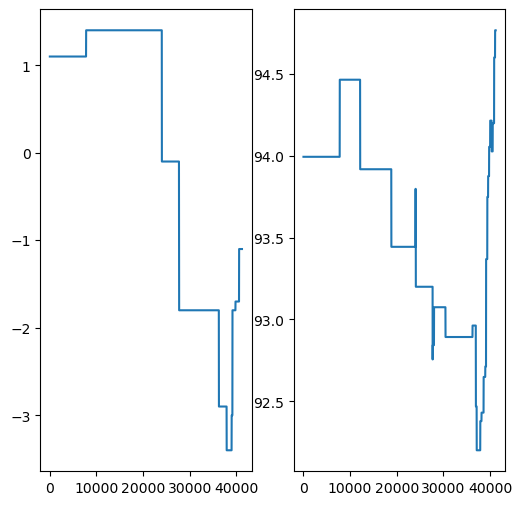

In [29]:
fig = plt.figure(figsize=(6,6))
j=1

for i in ['emp.var.rate', 'cons.price.idx']:
    plt.subplot(1,2,j)
    SE[i].plot()
    j = j+1
plt.show()

In [30]:

SE['emp.var.rate'] = SE['emp.var.rate'].apply(lambda x:
                                            ">0" if x >= 0 else
                                            "-2~0" if 0 > x >=-2 else
                                            "<-2"         
                                            )

In [31]:
SE['cons.price.idx'] = SE['cons.price.idx'].apply(lambda x:
                                                ">94" if x >= 94 else
                                                "93~94" if 94 > x >= 93 else
                                                "<93" 
                                                )

## Choose variables and instantiate bayesian network model with edges

In [32]:
# create new data frame with the target data
df = pd.concat([SE[['emp.var.rate', 'cons.price.idx']], 
                bank_full[['age', 'education','marital', 'job', 'y']]
               ], axis=1)

In [33]:
# quick look at target data
df.head()

,emp.var.rate,cons.price.idx,age,education,marital,job,y
0,>0,93~94,2.>50,basic,married,housemaid,no
1,>0,93~94,2.>50,high.school,married,services,no
2,>0,93~94,1.30~50,high.school,married,services,no
3,>0,93~94,1.30~50,basic,married,admin.,no
4,>0,93~94,2.>50,high.school,married,services,no


## Calculate CPD values (visualize in two decimal place)

### P('cons.price.idx') 

In [34]:
pd.crosstab(df['cons.price.idx'], 'Empty', margins = False, normalize = 'columns').apply(lambda x: round(x,2))
  

col_0,Empty
cons.price.idx,
93~94,0.64
<93,0.22
>94,0.14


### P('age')

In [35]:
pd.crosstab(df['age'], 'Empty', margins = False, normalize = 'columns').apply(lambda x: round(x,2))

col_0,Empty
age,
0.<30,0.18
1.30~50,0.65
2.>50,0.17


### P('emp.var.rate'|'cons.price.idx')

In [36]:
pd.crosstab(df['emp.var.rate'],df['cons.price.idx'], margins = True, normalize = 'columns').apply(lambda x: round(x,2))

cons.price.idx,93~94,<93,>94,All
emp.var.rate,,,,
-2~0,0.26,0.68,0.24,0.35
<-2,0.00,0.32,0.00,0.07
>0,0.74,0.00,0.76,0.58


### P('education'|'age')

In [37]:
pd.crosstab(df['education'],df['age'], margins = True, normalize = 'columns').apply(lambda x: round(x,2))

age,0.<30,1.30~50,2.>50,All
education,,,,
basic,0.23,0.30,0.39,0.30
high.school,0.31,0.23,0.17,0.23
professional.course,0.11,0.13,0.12,0.13
university.degree,0.31,0.30,0.26,0.30
unknown,0.04,0.03,0.06,0.04


### P('marital'|'age')

In [38]:
pd.crosstab(df['marital'],df['age'], margins = True, normalize = 'columns').apply(lambda x: round(x,2))

age,0.<30,1.30~50,2.>50,All
marital,,,,
divorced,0.03,0.12,0.19,0.11
married,0.32,0.64,0.76,0.61
single,0.64,0.24,0.05,0.28


#### P('job'|'education', 'marital')

In [39]:
pd.crosstab(df['job'],[df['education'],df['marital']], margins = True, normalize = 'columns').apply(lambda x: round(x,2))

education        basic                high.school                 \
marital       divorced married single    divorced married single   
job                                                                
admin.            0.08    0.05   0.09        0.37    0.33   0.37   
blue-collar       0.45    0.61   0.60        0.06    0.09   0.11   
entrepreneur      0.02    0.04   0.02        0.04    0.03   0.01   
housemaid         0.08    0.06   0.02        0.02    0.02   0.01   
management        0.02    0.03   0.02        0.03    0.04   0.01   
retired           0.14    0.07   0.01        0.04    0.04   0.01   
self-employed     0.02    0.03   0.02        0.01    0.01   0.01   
services          0.10    0.05   0.08        0.29    0.30   0.25   
student           0.00    0.00   0.06        0.00    0.00   0.11   
technician        0.05    0.04   0.05        0.10    0.09   0.09   
unemployed        0.03    0.03   0.03        0.03    0.03   0.02   

education     professional.course                university.degree          \
marital                  divorced married single          divorced married   
job                                                                          
admin.                       0.07    0.07   0.07              0.50    0.43   
blue-collar                  0.05    0.11   0.06              0.00    0.00   
entrepreneur                 0.02    0.03   0.01              0.06    0.06   
housemaid                    0.02    0.01   0.01              0.01    0.01   
management                   0.02    0.02   0.01              0.18    0.22   
retired                      0.08    0.06   0.01              0.04    0.03   
self-employed                0.04    0.04   0.02              0.05    0.07   
services                     0.04    0.04   0.05              0.01    0.01   
student                      0.00    0.00   0.03              0.00    0.00   
technician                   0.63    0.60   0.72              0.11    0.13   
unemployed                   0.03    0.03   0.01              0.02    0.02   

education             unknown                  All  
marital       single divorced married single        
job                                                 
admin.          0.53     0.14    0.16   0.16  0.26  
blue-collar     0.01     0.32    0.32   0.18  0.23  
entrepreneur    0.03     0.05    0.04   0.01  0.04  
housemaid       0.01     0.05    0.03   0.01  0.03  
management      0.09     0.07    0.10   0.03  0.07  
retired         0.01     0.05    0.09   0.01  0.04  
self-employed   0.06     0.02    0.02   0.02  0.03  
services        0.02     0.09    0.09   0.09  0.10  
student         0.03     0.02    0.00   0.35  0.02  
technician      0.19     0.18    0.13   0.12  0.17  
unemployed      0.02     0.01    0.01   0.01  0.02

### P('y'|'emp.var.rate', 'job')

In [40]:
pd.crosstab(df['y'], [df['emp.var.rate'],df['job']], margins = True, normalize = 'columns').apply(lambda x: round(x,2)).T

y                             no   yes
emp.var.rate job                      
-2~0         admin.         0.80  0.20
             blue-collar    0.90  0.10
             entrepreneur   0.90  0.10
             housemaid      0.76  0.24
             management     0.86  0.14
             retired        0.62  0.38
             self-employed  0.85  0.15
             services       0.89  0.11
             student        0.64  0.36
             technician     0.82  0.18
             unemployed     0.78  0.22
<-2          admin.         0.60  0.40
             blue-collar    0.66  0.34
             entrepreneur   0.66  0.34
             housemaid      0.60  0.40
             management     0.62  0.38
             retired        0.59  0.41
             self-employed  0.69  0.31
             services       0.61  0.39
             student        0.58  0.42
             technician     0.60  0.40
             unemployed     0.63  0.37
>0           admin.         0.95  0.05
             blue-collar    0.95  0.05
             entrepreneur   0.95  0.05
             housemaid      0.97  0.03
             management     0.95  0.05
             retired        0.94  0.06
             self-employed  0.95  0.05
             services       0.95  0.05
             student        0.94  0.06
             technician     0.96  0.04
             unemployed     0.96  0.04
All                         0.89  0.11

## Define the network

In [41]:
# model with list of edges
model = BayesianNetwork([ ('price_idx', 'emp_rate'), ('age', 'edu'),
                         ('age', 'marital'), ('age', 'job'),('marital', 'job'), 
                         ('edu', 'job'), ('job', 'y'), ('emp_rate', 'y')])

In [42]:
# check the leave node
model.get_leaves()

['y']

In [43]:
# children nodes of 'age'
model.get_children('age')

['edu', 'marital', 'job']

## Build Conditional Probability Cards (CPDs)

### CPD of price_idx

In [44]:
cpd_price_idx = TabularCPD(
    variable = 'price_idx',
    variable_card=3,
    values=[[0.64],[0.22],[0.14]],
    state_names={
        'price_idx':['93~94', '<93', '>94']
    }
)

### CPD of emp_rate

In [45]:
cpd_emp_rate = TabularCPD(
    variable = 'emp_rate',
    variable_card=3,
    evidence = ['price_idx'],
    evidence_card=[3],
    values=[ 
       [0.25835564, 0.67909275, 0.2440049 ],
       [0.        , 0.32090725, 0.        ],
       [0.74164436, 0.        , 0.7559951 ]
           
    ], 
    state_names={ 
        'emp_rate': ['-2~0', '<-2', '>0'],
        'price_idx':['93~94', '<93', '>94']
    }
)

### CPD of age

In [46]:
cpd_age = TabularCPD(
    variable = 'age',
    variable_card=3,
    values=[
        [0.17996517],
       [0.64723197],
       [0.17280286]],
    state_names={
        'age': ['0.<30', '1.30~50', '2.>50']
    }
)

### CPD of education

In [47]:
cpd_edu = TabularCPD(
    variable = 'edu',
    variable_card=5,
    evidence=['age'],
    evidence_card=[3],
    values=[ 
       [0.23320158, 0.3015879 , 0.38594748],
       [0.31007224, 0.22776367, 0.16735273],
       [0.1087638 , 0.13468754, 0.12391767],
       [0.30898187, 0.30291431, 0.26061036],
       [0.03898051, 0.03304658, 0.06217175]      
    ],
    state_names={
        'edu': ['basic', 'high.school', 'professional.course', 'university.degree','unknown'],
        'age': ['0.<30', '1.30~50', '2.>50']
    }
)

### CPD of marital

In [48]:
cpd_marital = TabularCPD(
    variable = 'marital',
    variable_card=3,
    evidence=['age'],
    evidence_card=[3],
    values=[ 
       [0.03107537, 0.11535984, 0.18807665],
       [0.32479215, 0.64232387, 0.758978  ],
       [0.64413248, 0.24231629, 0.05294535]       
    ],
    state_names={
        'marital': ['divorced', 'married', 'single'],
        'age': ['0.<30', '1.30~50', '2.>50']
    }
)

### CPD of job

In [49]:
cpd_job = TabularCPD(
    variable = 'job',
    variable_card=11,
    evidence=['edu', 'marital','age'],
    evidence_card=[5,3,3],
    values=[
        [0.13461538, 0.08224543, 0.0626506 , 0.042362  , 0.04868852,
        0.05553027, 0.07386364, 0.09157509, 0.13084112, 0.30337079,
        0.40423032, 0.27309237, 0.38073394, 0.34135546, 0.272203  ,
        0.32049608, 0.42487047, 0.36507937, 0.15384615, 0.06302521,
        0.09677419, 0.0648855 , 0.06759802, 0.06006006, 0.09215686,
        0.06519208, 0.05769231, 0.52830189, 0.55386417, 0.3962704 ,
        0.48963317, 0.45544111, 0.30132709, 0.52110901, 0.54208754,
        0.53174603, 0.125     , 0.03092784, 0.27272727, 0.32786885,
        0.15118397, 0.13095238, 0.09677419, 0.2079646 , 0.36      ],
       [0.46153846, 0.54308094, 0.29156627, 0.75353017, 0.67016393,
        0.39827037, 0.59886364, 0.62728938, 0.3271028 , 0.14606742,
        0.05757932, 0.03614458, 0.09785933, 0.09488243, 0.05767013,
        0.0926893 , 0.13212435, 0.01587302, 0.        , 0.06722689,
        0.01935484, 0.1221374 , 0.11762055, 0.06306306, 0.05294118,
        0.06519208, 0.        , 0.        , 0.00234192, 0.        ,
        0.00797448, 0.00492611, 0.00312256, 0.01071204, 0.01646091,
        0.        , 0.5       , 0.36082474, 0.25974026, 0.27868852,
        0.42622951, 0.16666667, 0.13824885, 0.2079646 , 0.36      ],
       [0.07692308, 0.02741514, 0.00963855, 0.03594352, 0.04180328,
        0.03186163, 0.00568182, 0.02289377, 0.05607477, 0.01123596,
        0.03642773, 0.04417671, 0.01987768, 0.03651452, 0.01730104,
        0.01044386, 0.00906736, 0.        , 0.        , 0.02521008,
        0.01935484, 0.05343511, 0.03064443, 0.02702703, 0.00588235,
        0.01979045, 0.        , 0.03773585, 0.05386417, 0.07925408,
        0.03668262, 0.06739812, 0.07025761, 0.01764335, 0.02880658,
        0.05555556, 0.        , 0.05154639, 0.06493506, 0.01639344,
        0.04918033, 0.04166667, 0.        , 0.01327434, 0.08      ],
       [0.        , 0.07049608, 0.1060241 , 0.01797176, 0.05016393,
        0.08784706, 0.00454545, 0.02197802, 0.04672897, 0.        ,
        0.02115159, 0.03614458, 0.02599388, 0.02130014, 0.02652826,
        0.00718016, 0.0123057 , 0.        , 0.        , 0.01260504,
        0.03225806, 0.00381679, 0.00901307, 0.01951952, 0.        ,
        0.0104773 , 0.09615385, 0.        , 0.0117096 , 0.01398601,
        0.01116427, 0.01298701, 0.0156128 , 0.00252048, 0.01122334,
        0.01587302, 0.        , 0.01030928, 0.1038961 , 0.        ,
        0.01821494, 0.05059524, 0.00460829, 0.02212389, 0.        ],
       [0.05769231, 0.02349869, 0.00963855, 0.01283697, 0.02885246,
        0.04369595, 0.01363636, 0.02197802, 0.07476636, 0.02247191,
        0.02820212, 0.04016064, 0.00917431, 0.04923928, 0.03690888,
        0.00652742, 0.02266839, 0.        , 0.        , 0.01260504,
        0.0516129 , 0.        , 0.01847679, 0.03153153, 0.00196078,
        0.0104773 , 0.05769231, 0.01886792, 0.16861827, 0.23076923,
        0.12759171, 0.22503359, 0.27010148, 0.0863264 , 0.09165731,
        0.03174603, 0.        , 0.10309278, 0.02597403, 0.01639344,
        0.11657559, 0.09821429, 0.01382488, 0.03982301, 0.04      ],
       [0.        , 0.01305483, 0.40481928, 0.        , 0.00819672,
        0.25216204, 0.00340909, 0.01373626, 0.12149533, 0.        ,
        0.00117509, 0.20080321, 0.        , 0.0033195 , 0.22145329,
        0.00065274, 0.00259067, 0.25396825, 0.        , 0.00840336,
        0.30322581, 0.        , 0.00315457, 0.25525526, 0.00196078,
        0.        , 0.23076923, 0.        , 0.00234192, 0.12820513,
        0.        , 0.00067174, 0.15612802, 0.        , 0.00112233,
        0.16666667, 0.        , 0.        , 0.11688312, 0.        ,
        0.00728597, 0.24107143, 0.        , 0.        , 0.16      ],
       [0.        , 0.02872063, 0.00963855, 0.01797176, 0.03377049,
        0.02503414, 0.00681818, 0.02106227, 0.05607477, 0.        ,
        0.01057579, 0.01204819, 0.00917431, 0.01604426, 0.00922722,
        0.00522193, 0.01489637, 0.04761905, 0.        , 0.03991597,
        0.02580645, 0.07633588, 0.03109509, 0.03303303, 0.01960784,
        0.02444703, 0.01923077, 0.11320755, 0.05854801, 0.02797203,
        0.08931419, 0.0575459 , 0.08821233, 0.08128544, 0.04938272,
        0.07142857, 0.        , 0.03092784, 0.01298701, 0.01639344,
        0.01821494, 0.01785714, 0.01843318, 0.01769912, 0.        ],
       [0.23076923, 0.11227154, 0.05060241, 0.05776637, 0.0547541 ,
        0.03413746, 0.06931818, 0.09615385, 0.06542056, 0.38202247,
        0.29259694, 0.26506024, 0.34556575, 0.31147994, 0.23298731,
        0.25391645, 0.23834197, 0.28571429, 0.03846154, 0.04621849,
        0.02580645, 0.07251908, 0.04326273, 0.01501502, 0.06470588,
        0.03725262, 0.        , 0.        , 0.01522248, 0.01631702,
        0.02392344, 0.01074787, 0.0078064 , 0.02772527, 0.01346801,
        0.        , 0.        , 0.13402062, 0.05194805, 0.24590164,
        0.08743169, 0.07440476, 0.09677419, 0.10176991, 0.        ],
       [0.        , 0.00130548, 0.        , 0.        , 0.00032787,
        0.        , 0.14431818, 0.00641026, 0.        , 0.        ,
        0.        , 0.        , 0.00611621, 0.00276625, 0.        ,
        0.21475196, 0.00906736, 0.        , 0.        , 0.00210084,
        0.        , 0.        , 0.00270392, 0.        , 0.06666667,
        0.00232829, 0.        , 0.        , 0.00468384, 0.        ,
        0.02392344, 0.00044783, 0.        , 0.06616257, 0.01646091,
        0.        , 0.125     , 0.02061856, 0.        , 0.        ,
        0.00364299, 0.        , 0.55299539, 0.18584071, 0.        ],
       [0.03846154, 0.05483029, 0.03614458, 0.0436457 , 0.03721311,
        0.04642695, 0.05909091, 0.04487179, 0.04672897, 0.08988764,
        0.11633373, 0.05220884, 0.05963303, 0.09598893, 0.09803922,
        0.06657963, 0.11334197, 0.03174603, 0.80769231, 0.69117647,
        0.4       , 0.57251908, 0.6408292 , 0.47447447, 0.68235294,
        0.74738068, 0.53846154, 0.26415094, 0.11358314, 0.09090909,
        0.16427432, 0.14151366, 0.07259953, 0.16446125, 0.20538721,
        0.12698413, 0.25      , 0.24742268, 0.09090909, 0.08196721,
        0.10928962, 0.16369048, 0.07373272, 0.18584071, 0.        ],
       [0.        , 0.04308094, 0.01927711, 0.01797176, 0.02606557,
        0.02503414, 0.02045455, 0.03205128, 0.07476636, 0.04494382,
        0.03172738, 0.04016064, 0.04587156, 0.02710927, 0.02768166,
        0.02154047, 0.02072539, 0.        , 0.        , 0.03151261,
        0.02580645, 0.03435115, 0.03560162, 0.02102102, 0.01176471,
        0.01746217, 0.        , 0.03773585, 0.01522248, 0.01631702,
        0.02551834, 0.02328706, 0.01483216, 0.02205419, 0.02394314,
        0.        , 0.        , 0.01030928, 0.        , 0.01639344,
        0.01275046, 0.01488095, 0.00460829, 0.01769912, 0.        ]
       ],
    state_names={
        'job': ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
               'retired', 'self-employed', 'services', 'student', 'technician','unemployed'],
        'edu': ['basic', 'high.school', 'professional.course', 'university.degree','unknown'],
        'marital': ['divorced', 'married', 'single'],
        'age': ['0.<30', '1.30~50', '2.>50']
    }

)


### CPD of y

In [50]:
cpd_y = TabularCPD(
    variable = 'y',
    variable_card=2,
    evidence=['emp_rate','job'],
    evidence_card=[3,11],
    values=[
        [0.80300083, 0.90314465, 0.89643463, 0.76339286, 0.86166667,
        0.6179966 , 0.84554455, 0.8913649 , 0.64285714, 0.81559588,
        0.78393352, 0.60107527, 0.65882353, 0.6557377 , 0.60493827,
        0.61904762, 0.5920398 , 0.68867925, 0.60655738, 0.5840708 ,
        0.59850374, 0.6328125 , 0.95406601, 0.95426726, 0.95006242,
        0.97203728, 0.95033557, 0.94174757, 0.95386534, 0.95051975,
        0.93604651, 0.95548823, 0.96346154],
       [0.19699917, 0.09685535, 0.10356537, 0.23660714, 0.13833333,
        0.3820034 , 0.15445545, 0.1086351 , 0.35714286, 0.18440412,
        0.21606648, 0.39892473, 0.34117647, 0.3442623 , 0.39506173,
        0.38095238, 0.4079602 , 0.31132075, 0.39344262, 0.4159292 ,
        0.40149626, 0.3671875 , 0.04593399, 0.04573274, 0.04993758,
        0.02796272, 0.04966443, 0.05825243, 0.04613466, 0.04948025,
        0.06395349, 0.04451177, 0.03653846]
        ],
    state_names={
        'y': ['no', 'yes' ],
        'emp_rate': ['-2~0', '<-2', '>0'],
        'job': ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
               'retired', 'self-employed', 'services', 'student', 'technician','unemployed'],
    }
)

## Associate the CPDs to the network

In [51]:
model.add_cpds(cpd_price_idx, cpd_emp_rate, cpd_age, cpd_edu, cpd_marital, cpd_job, cpd_y)

### Plot the network

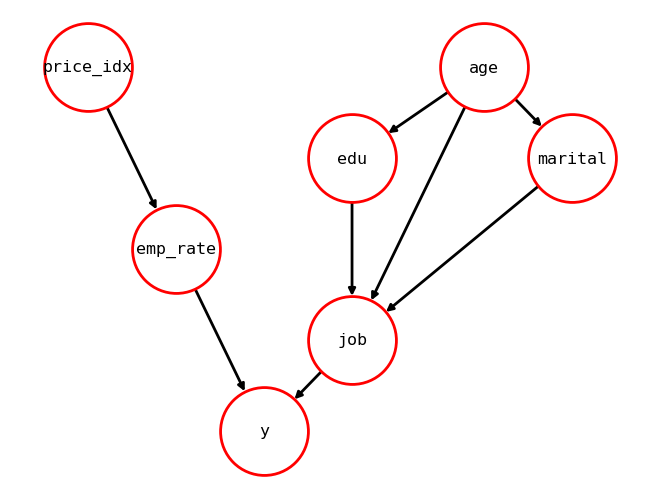

In [52]:
pos = {'price_idx': (0, 0), 'emp_rate': (1, -2),
       'y': (2, -4), 'job': (3, -3), 'edu': (3, -1),
       'marital':(5.5,-1), 'age': (4.5,0)}
options = {
    "with_labels": True,
    "font_size": 12,
    "node_size": 4000,
    "node_color": 'white',
    "node_shape": 'o',
    "edgecolors": "red",
    "linewidths": 2,
    "width": 2,
    "font_family": 'monospace' # 'fantasy' 'monospace'
}

nx.draw(model, pos, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

## Understanding the model

In [53]:
# check the network structure and CPDs, 
# verify if the CPDs are correctly defined and sum to 1.
model.check_model()

True

In [54]:
# list all cpds
model.get_cpds()

[<TabularCPD representing P(price_idx:3) at 0x2465f9e3d00>,
 <TabularCPD representing P(emp_rate:3 | price_idx:3) at 0x2465fa007c0>,
 <TabularCPD representing P(age:3) at 0x2465f9f2c10>,
 <TabularCPD representing P(edu:5 | age:3) at 0x2465fa00550>,
 <TabularCPD representing P(marital:3 | age:3) at 0x2465fa002e0>,
 <TabularCPD representing P(job:11 | edu:5, marital:3, age:3) at 0x2465fa005e0>,
 <TabularCPD representing P(y:2 | emp_rate:3, job:11) at 0x2465fbd74c0>]

In [55]:
# check cpd of 'y'
print(model.get_cpds('y'))

+----------+----------------+------------------+-----+--------------+-----------------+-----------------+
| emp_rate | emp_rate(-2~0) | emp_rate(-2~0)   | ... | emp_rate(>0) | emp_rate(>0)    | emp_rate(>0)    |
+----------+----------------+------------------+-----+--------------+-----------------+-----------------+
| job      | job(admin.)    | job(blue-collar) | ... | job(student) | job(technician) | job(unemployed) |
+----------+----------------+------------------+-----+--------------+-----------------+-----------------+
| y(no)    | 0.80300083     | 0.90314465       | ... | 0.93604651   | 0.95548823      | 0.96346154      |
+----------+----------------+------------------+-----+--------------+-----------------+-----------------+
| y(yes)   | 0.19699917     | 0.09685535       | ... | 0.06395349   | 0.04451177      | 0.03653846      |
+----------+----------------+------------------+-----+--------------+-----------------+-----------------+


In [56]:
# check independencies 
model.get_independencies()

(price_idx ⟂ age, marital, edu, job)
(price_idx ⟂ age, job, edu | marital)
(price_idx ⟂ age, marital, job | edu)
(price_idx ⟂ marital, edu, age, job, y | emp_rate)
(price_idx ⟂ marital, job, edu | age)
(price_idx ⟂ age, marital, edu | job)
(price_idx ⟂ age, job | marital, edu)
(price_idx ⟂ age, job, edu, y | marital, emp_rate)
(price_idx ⟂ job, edu | age, marital)
(price_idx ⟂ age, edu | marital, job)
(price_idx ⟂ age, marital, job, y | edu, emp_rate)
(price_idx ⟂ marital, job | age, edu)
(price_idx ⟂ age, marital | edu, job)
(price_idx ⟂ job, marital, edu, y | age, emp_rate)
(price_idx ⟂ age, marital, edu, y | job, emp_rate)
(price_idx ⟂ age, marital, edu, job | y, emp_rate)
(price_idx ⟂ marital, edu | age, job)
(price_idx ⟂ age, marital, edu | job, y)
(price_idx ⟂ age, job, y | marital, edu, emp_rate)
(price_idx ⟂ job | age, marital, edu)
(price_idx ⟂ age | marital, edu, job)
(price_idx ⟂ job, edu, y | age, marital, emp_rate)
(price_idx ⟂ age, edu, y | marital, job, emp_rate)
(price_

In [57]:
# all reachable nodes of 'y' from the graph
model.active_trail_nodes("y")

{'y': {'age', 'edu', 'emp_rate', 'job', 'marital', 'price_idx', 'y'}}

In [58]:
# all reachable nodes of 'edu' from the graph
model.active_trail_nodes("edu")

{'edu': {'age', 'edu', 'job', 'marital', 'y'}}

## Make inference

### What is the subscription rate, given no other information? 
What is the probability of customer subscribe a term deposit given no other information? 

In [59]:
infer = VariableElimination(model)

In [60]:
y_distribution = infer.query(variables=['y'])

In [61]:
print(y_distribution)

+--------+----------+
| y      |   phi(y) |
+========+==========+
| y(no)  |   0.8878 |
+--------+----------+
| y(yes) |   0.1122 |
+--------+----------+


### What should be the marketing strategy given the assumed economic environment ( emp_rate <-2, price_idx >94)?
What is the bank term deposit subscription rate given ( emp_rate <-2, price_idx >94) ? 

In [62]:
y_given_0_94 = infer.query(
    variables = ['y'],
    evidence = {'price_idx':'>94', 'emp_rate':'<-2'}
)
print(y_given_0_94)

+--------+----------+
| y      |   phi(y) |
+========+==========+
| y(no)  |   0.6206 |
+--------+----------+
| y(yes) |   0.3794 |
+--------+----------+


Assuming the current market subscription rate is the same as the baseline (around 11% when no prior information is given). If the predicted rate is higher than the current rate of 11%, we provide signals of an "increasing" market. Else, "shrinking" market. In the assumed economic environment, the system will signal management of an "increasing" market as the subscription rate is much higher than 11%. 

### What is the resource allocation decision with a locational population distribution high in technicians in the current market?

In [63]:
y_given_technician = infer.query(
    variables = ['y'],
    evidence = { 'job': "technician",'price_idx':'>94', 'emp_rate':'<-2'}
)
print(y_given_technician)

+--------+----------+
| y      |   phi(y) |
+========+==========+
| y(no)  |   0.5985 |
+--------+----------+
| y(yes) |   0.4015 |
+--------+----------+


Assuming three cities have similar population sizes, one city’s workforce is dominated by technicians, and it has much higher technicians than the sum of the other two cities. Shall we allocate more resources to the city populated with technicians? Or equally split resources among three cities? Based on our Bayesian network, we should allocate more resources to the city dominated by technicians as the subscription rate(around 40%) is higher than average(around 38%) in the assumed economic background.